# Churn Analysis and Prediction for Octopus Energy

Octopus is a renewable energy company with a strong commitment to sustainability and efficiency. Like many other companies, one of the main challenges it faces is churn, or customer churn rate. Churn is a crucial indicator for measuring customer satisfaction and loyalty and represents the percentage of customers who stop using the service offered by the company in a given period of time. In sectors such as energy, where loyalty is crucial for long-term sustainability and growth, reducing churn is essential.

Predicting churn is crucial to identify customers at risk of churn in advance and take targeted corrective measures to prevent their loss. Since acquiring new customers is more expensive than retaining existing ones, understanding the reasons why customers leave is a crucial step. Only in this way is it possible to implement effective strategies to improve customer experience and satisfaction while minimising the risk of switching to competitors. To this end, churn analysis helps to identify the factors that influence customers' decision to leave, providing insights to implement corrective actions.
To address this issue, the study adopted the use of machine learning algorithms, such as Logistic Regression, Random Forest and XGBoost, to develop a predictive model capable of understanding churn cases. The goal is to identify risky customers before they make the final decision to abandon, allowing the company to implement targeted interventions to improve retention and reduce churn rates.

Finally, the project will focus on analysing the data provided by Octopus to identify the main causes of churn and develop a predictive model based on machine learning techniques, with the aim of reducing the churn rate and increasing overall customer satisfaction.

## Importing Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Geospatial data handling
import geopandas as gpd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

# Sampling techniques (imbalanced datasets)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Utility
import colorsys

import warnings
warnings.filterwarnings('ignore')

## Data Loading

The dataset delivered was provided by Octopus with the aim of analysing the churn phenomenon within the company. Initially, the first three attributes, relating to point of supply, customer and sign-up, were excluded, as they are anonymous information and not relevant for the analysis. In addition, the attributes relating to promotional code and referral code were also removed, as they did not provide greater utility for the purpose of churn prediction.

The dataset, consisting of 13,883 records corresponding to Octopus customers, includes 12 variables describing different characteristics of customers and their behaviour. These attributes provide useful information for understanding the factors influencing customer churn. The meaning of the different attributes is explained below.

- Sales channel: Indicates the sales channel through which the customer registered for the service. For example, a customer might have registered directly on the Octopus site, without going through intermediaries or external agents.
- Anonymised sales subchannel: This field represents an anonymised identifier describing a specific subchannel within the sales channel.
- Supply province: Indicates the province where the customer's supply point is located, that is, the geographical location of the electricity service.
- Age of customer: The age of the customer at the time of registration for the service. 
- Sex of customer: The sex of the customer.
- Type of voltura: This field refers to the voltura, which is the change of supply from the previous customer to the current one. 
- First product category : Refers to the type of contract activated by the customer at the time of becoming an Octopus customer.
- Last product category : Refers to the type of contract active for the customer at the time the dataset was created.
- Date of singup : The date on which the customer registered for the company's service.
- Supply start date : The date on which the service starts to be supplied.
- Supply end date: The end date of the supply of the service.
- Has churned: Binary variable (True / False) indicating whether the customer has left the service, in other words, whether they have churned. This attribute is the main object of the analysis, as it is used to determine whether a customer has stayed or left.

In [2]:
data = pd.read_csv("octopus_churn_case_study.csv")

## Data Preprocessing

In [3]:
data.head()

,anonymised_supplypoint_id,anonymised_customer_id,signup_id,sales_channel,anonymised_sales_subchannel,has_promo_code,has_referral_code,supply_province,age_of_customer,sex_of_customer,type_of_voltura_incoming,first_product_category,last_product_category,date_of_signup,supply_start_date,supply_end_date,has_churned
0,20816.0,27518,27518,Direct,ed168885785,False,False,TV,62.0,M,NaN,FIX,FIX,2023-06-20,2023-08-01,NaN,False
1,24793.0,30542,30542,Price Comparison,4c5627f1c90,False,False,BR,41.0,M,NaN,FIX,FIX,2023-06-30,2023-08-01,2023-08-31,True
2,14807.0,19106,19106,Price Comparison,4c5627f1c90,False,False,NU,68.0,M,NaN,FLEX,FLEX,2023-05-11,2023-07-01,NaN,False
3,34020.0,29626,29626,Price Comparison,4c5627f1c90,False,False,AG,53.0,M,NaN,FIX,FLEX,2023-06-27,2023-08-01,NaN,False
4,22669.0,28719,28719,Direct,ed168885785,False,False,MI,51.0,M,NaN,FIX,FLEX,2023-06-23,2023-08-01,NaN,False


In [4]:
data = data.drop(['anonymised_supplypoint_id', 'anonymised_customer_id', 'signup_id'], axis=1)

In [5]:
data['has_promo_code'].value_counts()

has_promo_code
False    13883
Name: count, dtype: int64

In [6]:
data['has_referral_code'].value_counts()

has_referral_code
False    13883
Name: count, dtype: int64

In [7]:
data = data.drop(['has_promo_code', 'has_referral_code'], axis=1)

## Exploratory Data Analysis (EDA)

In this phase of the project, the dataset will be analysed through an exploratory data analysis, using graphical visualisation techniques to identify any relationships or patterns between variables.

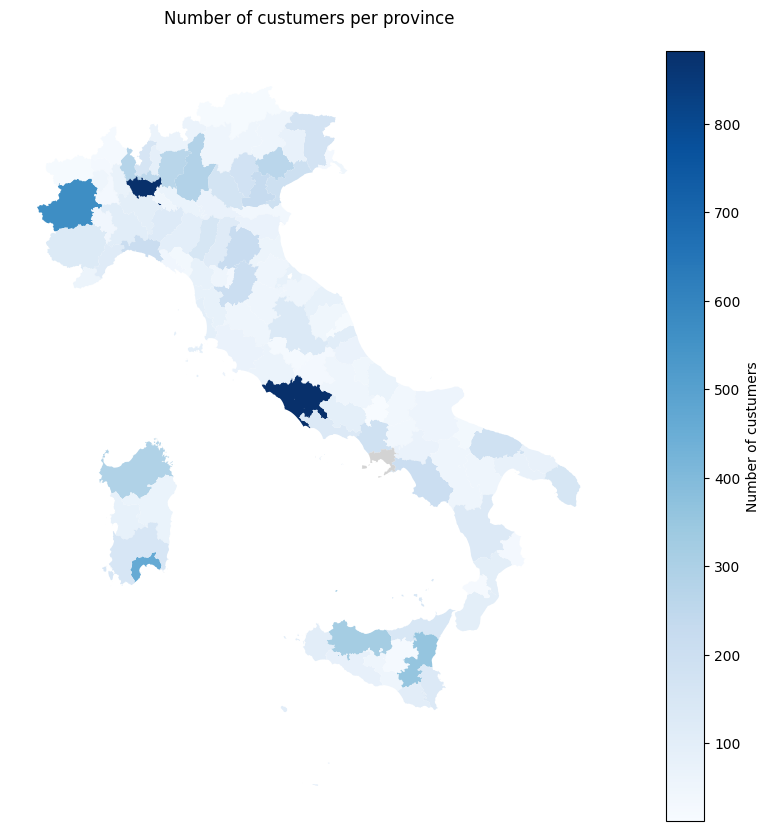

In [8]:
def plot_italy_provinces(data_dict):
    # https://www.istat.it/it/archivio/222527
    provinces = gpd.read_file('Map/ProvCM01012024_g_WGS84.shp')

    provinces['value'] = provinces['SIGLA'].map(data_dict)
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    
    provinces.plot(
        column='value',
        ax=ax,
        legend=True,
        legend_kwds={'label': 'Number of custumers'},
        missing_kwds={'color': 'lightgrey'},
        cmap='Blues'
    )
    ax.axis('off')
    plt.title('Number of custumers per province', pad=20)
    return fig

    

fig = plot_italy_provinces(data['supply_province'].value_counts().to_dict())
plt.show()

The first analysis concerns the distribution of Octopus customers by province. From the observation of the data, it is clear that the provinces with the highest concentration of customers are Milan and Rome, followed by Aosta, where there is also a significant presence of customers. These insights provide an interesting overview of the geographical distribution of customers. In addition, it must be said that there are missing values for the province of Naples.

### Gender Distribution by Province

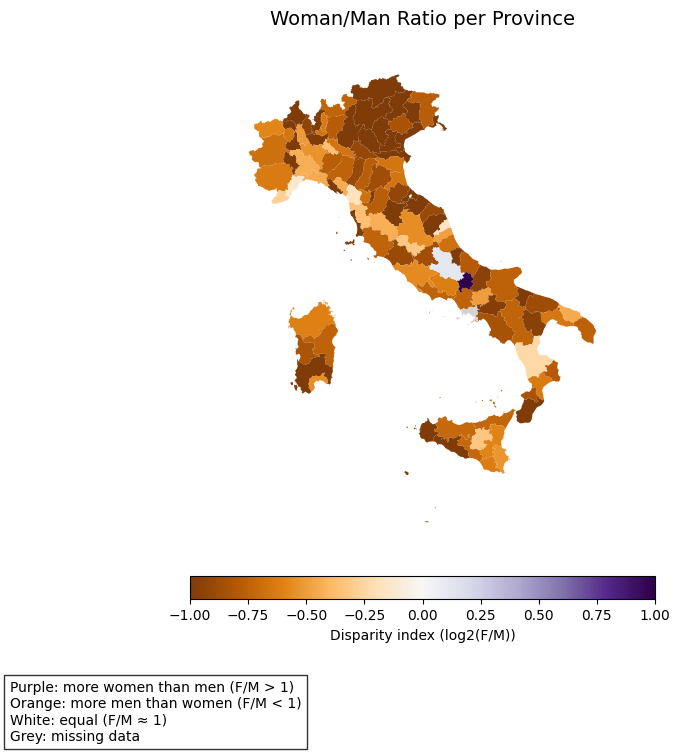

In [9]:
def plot_italy_gender_distribution(data):
    provinces = gpd.read_file('Map/ProvCM01012024_g_WGS84.shp')
    gender_counts = data.groupby(['supply_province', 'sex_of_customer']).size().unstack(fill_value=0)
    
    gender_counts['disparity_index'] = (gender_counts['F'] / gender_counts['M'])
    gender_counts['log_disparity'] = np.log2(gender_counts['disparity_index'])
    
    provinces['value'] = provinces['SIGLA'].map(gender_counts['log_disparity'])
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    provinces.plot(
        column='value',
        ax=ax,
        legend=True,
        legend_kwds={
            'label': 'Disparity index (log2(F/M))',
            'orientation': 'horizontal',
            'shrink': 0.6,
            'pad': 0.05
        },
        missing_kwds={'color': 'lightgrey'},
        cmap='PuOr', 
        vmin=-1,      
        vmax=1      
    )
    ax.axis('off')
    plt.title('Woman/Man Ratio per Province', pad=20, fontsize=14)
    
    plt.figtext(
        0.1, 0.02,
        'Purple: more women than men (F/M > 1)\n' +
        'Orange: more men than women (F/M < 1)\n' +
        'White: equal (F/M ≈ 1)\n' +
        'Grey: missing data',
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.8)
    )
    
    plt.show()

plot_italy_gender_distribution(data)

In [10]:
sum(data['supply_province']=='IS')

12

The second graph shows the distribution of male and female customers by province. To analyse this distribution, a disparity index was created, which takes different values depending on the predominance of one gender over the other. The index has a value greater than one when there is a female predominance, less than one when there is a male predominance and equal to one when the distribution is equal.

It is clear from the data that, in almost all Italian provinces, there is a clear male predominance, with particularly high values in the north-eastern provinces. The only exception found is in the province of Isernia, in Molise, where the female customers predominate, causing the inequality index to take on a value greater than one. Nevertheless, it must be stated that there are only 12 costumers in total in the province.

### Gender Distribution Pie Chart

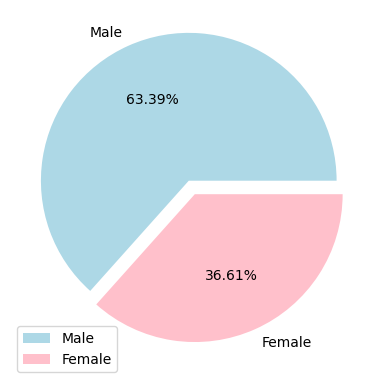

In [11]:
colors = ['lightblue','pink']
x = round(data["sex_of_customer"].value_counts()/data.shape[0]*100,2)
plt.pie(x,labels = ["Male", "Female"],colors=colors,  explode = [0.1,0], autopct= '%.2f%%')
plt.legend()
plt.show()

A pie chart shows the gender distribution of Octopus' total customers. The chart confirms the trend observed previously with a clear majority of male customers.

### Age Distribution of Customers

In [12]:
data_age = data.copy()
data_age['age_category'] = pd.cut(data_age['age_of_customer'], bins=[0, 30, 40, 50, 100], labels=['Under 30', '30-40', '40-50', 'Over 50'])

In [13]:
def pie_plot(data, column, colors = ['lightblue', 'lightgreen', 'orange', 'pink', 'lightcoral']):
    x = round(data[column].value_counts()/data[column].shape[0]*100,2)
    plt.pie(x,labels = x.index, autopct= '%.2f%%', explode=[0.05]*len(x), colors=colors)
    plt.legend()
    plt.show()

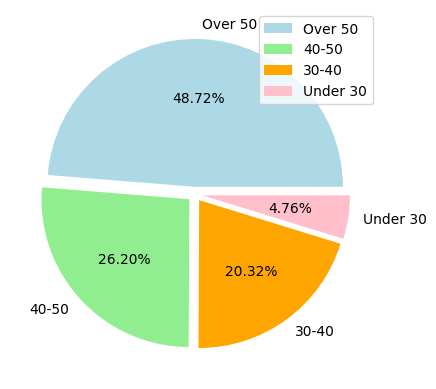

In [14]:
pie_plot(data_age, 'age_category')

Another significant aspect to be analysed concerns the age range of Octopus customers. The graph shows that almost half of the customers are over 50 years old (48.72%). The next age group, that between 40 and 50, has a higher percentage of customers (26.20%), followed by those between 30 and 40 (20.32%). Finally, the youngest category of customers, under 30, accounts for a small proportion of customers, with a percentage of less than 5%. 

### Product Category Distribution

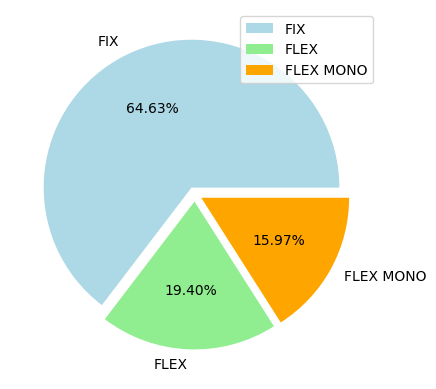

In [15]:
pie_plot(data,'first_product_category')

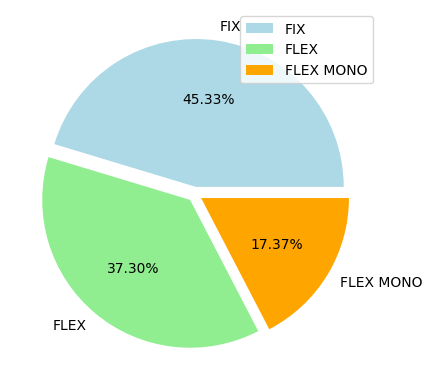

In [16]:
pie_plot(data,'last_product_category')

The two pie charts above show an interesting trend regarding changes in customers' preferences regarding contract types. In particular, it can be seen that many customers who previously preferred a fixed-rate contract, characterised by a stable tariff that is independent of market fluctuations, have chosen to switch to a flexible-rate contract, where the tariff varies according to fluctuations in the energy market. In contrast, the percentage of customers with a variable-rate contract, but with a single tariff applied for all hours of the day (Flex mono), remained essentially unchanged. This change in customer choice may reflect an increasing focus on the possibility of benefiting from more dynamic tariffs and the desire for greater flexibility in response to changes in energy costs.

### Churn Distribution

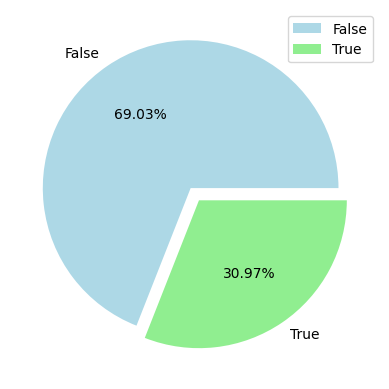

In [17]:
pie_plot(data,'has_churned')

Finally, the last pie chart shows that almost 70 % of customers did not churn, while 30 % of customers switched to another energy supplier. As expected the dataset is unbalanced, with a higher number of customers who did not churn compared to those who did.

### Sankey Chart for Customer Path

In [18]:
def create_sankey(data, columns, title="Sankey Chart"):
    def generate_colors(n):
        colors = []
        for i in range(n):
            hue = i / n
            rgb = colorsys.hsv_to_rgb(hue, 0.7, 0.9)
            rgba = f'rgba({int(rgb[0]*255)},{int(rgb[1]*255)},{int(rgb[2]*255)},0.8)'
            colors.append(rgba)
        return colors

    flow_data = data.groupby(columns).size().reset_index(name='count')
    
    unique_cats = []
    for col in columns:
        unique_cats.append(list(flow_data[col].unique()))
    
    colors_per_column = [generate_colors(len(cats)) for cats in unique_cats]
    
    all_nodes = []
    node_colors = []
    for cats, colors in zip(unique_cats, colors_per_column):
        all_nodes.extend(cats)
        node_colors.extend(colors)
    
    node_indices = {node: idx for idx, node in enumerate(all_nodes)}
    
    source = []
    target = []
    value = []
    paths = [] 
    
    for i in range(len(columns)-1):
        source_col = columns[i]
        target_col = columns[i+1]
        
        for _, row in flow_data.iterrows():
            src = node_indices[row[source_col]]
            tgt = node_indices[row[target_col]]
            source.append(src)
            target.append(tgt)
            value.append(row['count'])
            path = " → ".join([str(row[col]) for col in columns])
            paths.append(path) 
    
    link_colors = []
    for s in source:
        base_color = node_colors[s]
        rgba_values = base_color.replace('rgba(', '').replace(')', '').split(',')
        link_colors.append(f'rgba({rgba_values[0]},{rgba_values[1]},{rgba_values[2]},0.3)')
    
    hover_text = [f"Path: {path}<br>Value: {v}" for path, v in zip(paths, value)]
    
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=all_nodes,
            color=node_colors
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            color=link_colors,
            customdata=hover_text,  
            hovertemplate='%{customdata}<extra></extra>' 
        )
    )])
    
    annotations = []
    for i, col in enumerate(columns):
        x_pos = i / (len(columns) - 1) if len(columns) > 1 else 0.5
        annotations.append(
            dict(
                text=col,
                x=x_pos,
                y=1.05,
                showarrow=False,
                font=dict(size=12)
            )
        )
    
    fig.update_layout(
        title_text=title,
        font_size=10,
        height=800,
        annotations=annotations
    )
    
    return fig

In [19]:
data_age['last_product_category'] = data_age['last_product_category'] + " "

In [20]:
fig = create_sankey(
    data=data_age,
    columns=['age_category', 'first_product_category', 'last_product_category','has_churned'],
    title="Path of clients from age to first and last product category"
)
fig.show()

The analysis just carried out aims to visualise the path of customers within Octopus, using a Sankey chart. This graph follows the path of customers, starting from their age category, through the type of contract they initially entered into, to their last contract and finally to whether or not they churned from their energy supplier. The graph shows that the majority of customers who churned came from fixed-rate contracts. Furthermore, it can be seen that, over time, a large proportion of customers chose to switch to a flexible rate contract, with rare cases where the opposite was the case. The general trend shows a more pronounced growth in flexible-rate contracts.

There is no clear pattern in the age distribution of customers who churned, as the distribution is relatively uniform across all age groups.

Hoverlaing the connection of people that have FIX as last contract, it is clear that the majority of customers who churned had also FIX as their first contract. This suggests that customers who initially chose a fixed-rate contract were more likely to churn than those who chose a different type of contract. This information is crucial for understanding the factors that influence customer churn and for developing strategies to reduce it.

### Customer Distribution by Region

In [21]:
provinces = gpd.read_file('Map/ProvCM01012024_g_WGS84.shp')

In [22]:
provinces['zone'] = provinces['COD_RIP'].map({1: 'North-West', 2: 'North-East', 3: 'Center', 4: 'South', 5: 'Islands'})

In [23]:
data_age['zone'] = data_age['supply_province'].map(provinces.set_index('SIGLA')['zone'])

In [24]:
data_age['zone'].value_counts()

zone
North-West    4054
North-East    2533
Center        2447
Islands       2387
South         1900
Name: count, dtype: int64

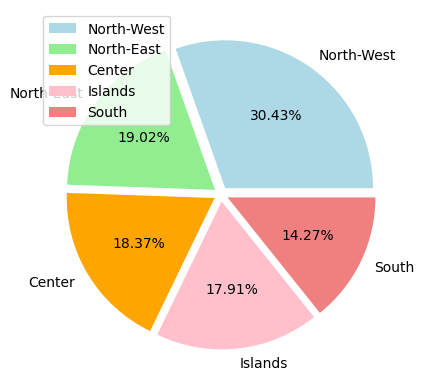

In [25]:
pie_plot(data_age,'zone')

In northern Italy, Octopus has the most customers, particularly in the north-west with more than 4,000 customers (30.43%). This is followed by the centre (18.37%), Sardinia and Sicily (17.91%) and, finally, the south (14.27%).

### Sankey Chart for Region to Product Category

In [26]:
create_sankey(
    data=data_age,
    columns=['zone', 'first_product_category', 'last_product_category','has_churned'],
    title="Path of clients from region to first and last product category"
).show()

The Sankey chart is the same as the above on the right part, on the left part shows how people of different regions choose different product categories. There is no significant difference between regions in terms of product category choice but we will study this further in the next steps.

### Stacked Bar Plot for Last Product Category and Churn

In the following graphs, we will have the opportunity to explore whether there is a correlation between the selected variables and a higher churn rate, with the aim of identifying the factors that most influence customer churn.

In [27]:
def plot_stacked_bar(data, group_columns, colors=['lightblue', 'orange']):
    grouped_data = data.groupby(group_columns).size().unstack()
    percent_data = (grouped_data.T * 100.0 / grouped_data.T.sum()).T
    
    ax = percent_data.plot(kind='bar', width=0.3, stacked=True, rot=0, figsize=(10, 6), color=colors)
    ax.legend(loc='best', prop={'size': 10}, title=group_columns[1].capitalize())
    ax.set_ylabel('% Customers', size=14)
    ax.set_title(f'{group_columns[1].capitalize()} by {group_columns[0].capitalize()}', size=14)

    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        if height > 0: 
            ax.annotate(
                f'{height:.0f}%',
                (x + 0.25 * width, y + 0.4 * height),
                color='white',
                weight='bold',
                size=12
            )

    plt.tight_layout()
    plt.show()


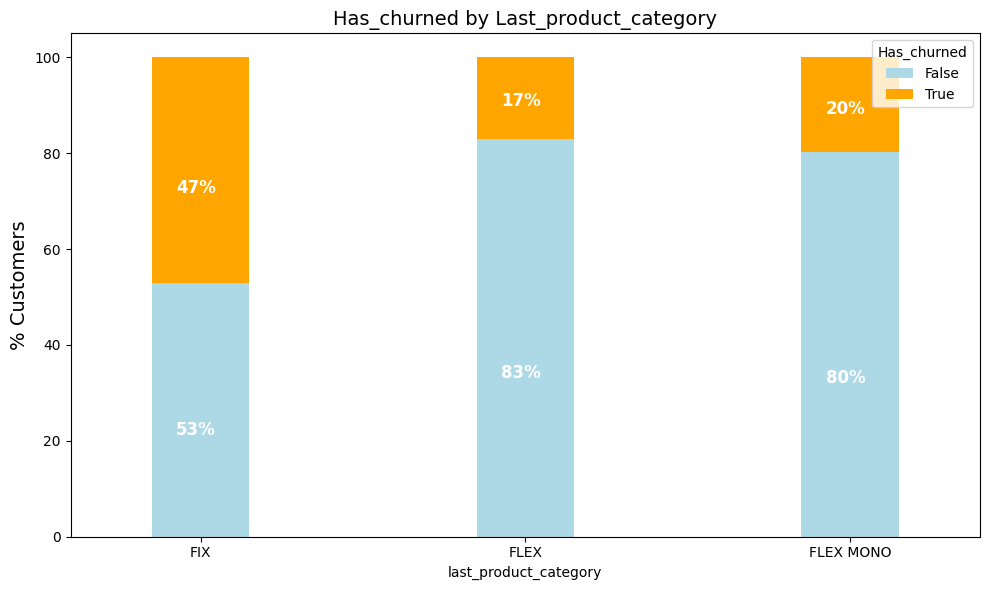

In [28]:
plot_stacked_bar(data, ['last_product_category', 'has_churned'])

With regard to the graph above, it can be observed that customers who have a fixed-rate contract with Octopus are more likely to churn. This suggests that fixed-rate contracts, although offering stability to customers, may not be sufficiently attractive compared to flexible-rate contracts, which offer greater adaptability to fluctuations in the energy market. The higher propensity to churn among customers with fixed-rate contracts may reflect lower satisfaction with the ability to adapt costs to external conditions.

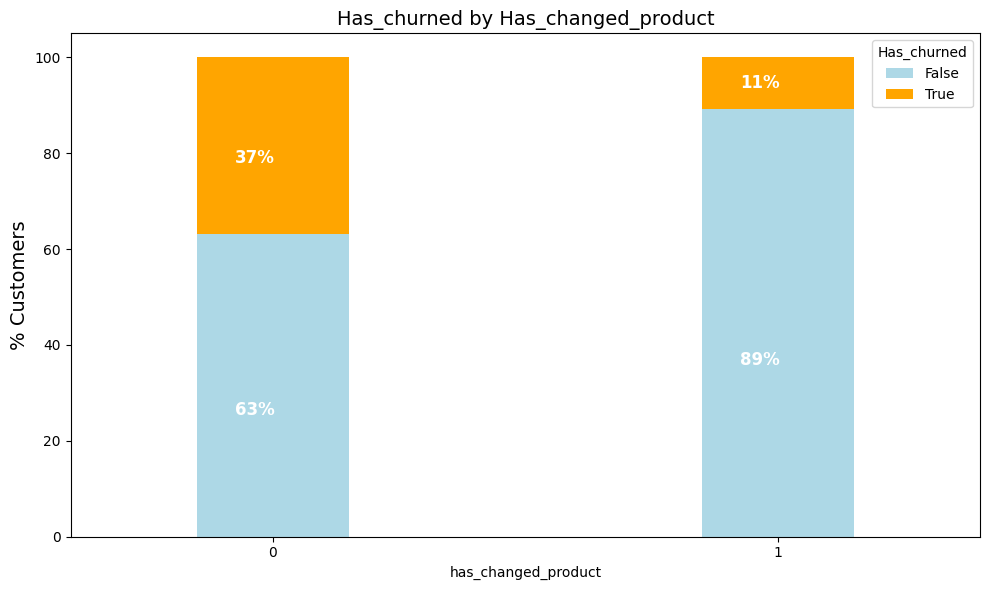

In [61]:
data['has_changed_product'] = (data['first_product_category'] != data['last_product_category']).astype(int)

plot_stacked_bar(data, ['has_changed_product', 'has_churned'])

This shows a significant difference between custumers that changed their contract type and those that did not. Custumers who don't change their contract type are more likely to churn than those who do. Maybe because the ones that change the contract type are more satisfied with the provider and just want to change the contract type.

### Stacked Bar Plot for Zone and Churn

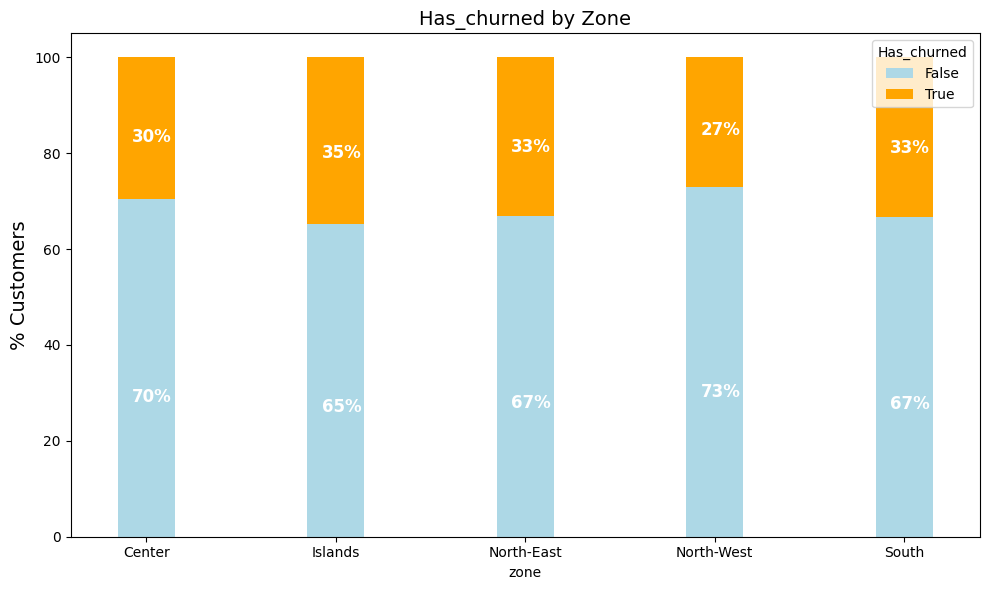

In [29]:
plot_stacked_bar(data_age, ['zone', 'has_churned'])

By using the this barplot, it can be seen that the islands, the south and the north-east of the Italian peninsula show a higher probability of churn than the central and north-western areas, but not in a significant way.

### Stacked Bar Plot for Age Category and Churn

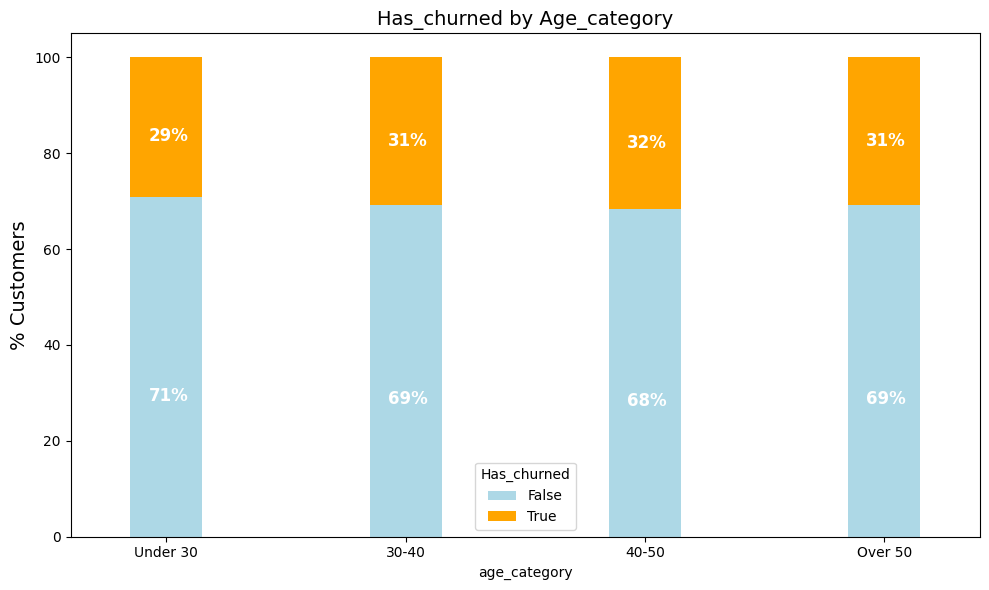

In [30]:
plot_stacked_bar(data_age, ['age_category', 'has_churned'])

As far as age groups are concerned, no significant differences are observed in the distribution of churn. In fact, all age groups show a variation around 30%, suggesting that, although there may be small fluctuations, age does not seem to be a determining factor in the churn rate. However, it is interesting to note that Octopus' younger customers tend to switch providers less frequently than the other groups, while those in the 40-50 age group show a greater predisposition to leave the service. Despite these differences, as already mentioned, the variation between the different age groups remains relatively small.

### Stacked Bar Plot for Sales Channel and Churn

In [31]:
data['sales_channel'].value_counts()

sales_channel
Price Comparison    7831
Direct              6013
Field Sales           36
New tenant             3
Name: count, dtype: int64

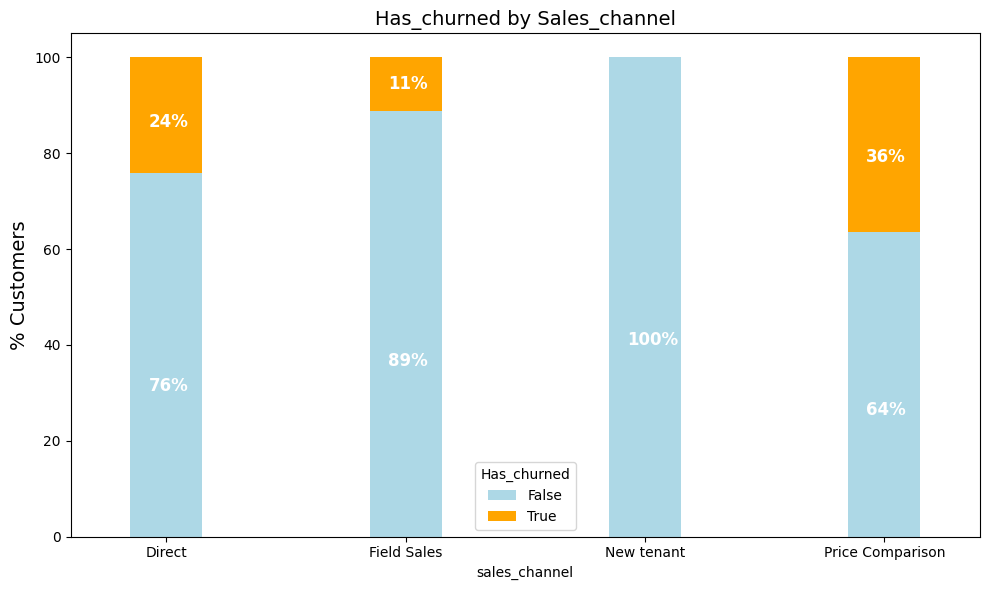

In [32]:
plot_stacked_bar(data, ['sales_channel', 'has_churned'])

The last graph of this type shows the most marked differences in relation to the various channels through which customers contracted with Octopus and their likelihood of churn. It can be seen that the majority of customers decided to switch electricity supplier for two main reasons: price comparison with other companies and direct decision. These two reasons emerged with a remarkably high frequency in the dataset, in comparison to the other reasons for churn, suggesting that price competitiveness and direct evaluation by customers are the main factors influencing the decision to leave the service. It must be stated, however, that these two values appeared in the dataset in an extremely massive way(7831 for 'Price Comparison' and 6013 for 'Direct'), compared to the other two (36 for 'Field sales' and only 3 for 'New tenant').

So comparing only 'Direct' and 'Price Comparison' we can say that customers who subscribed to Octopus through price comparison websites are more likely to churn than those who subscribed directly. This suggests that customers who have chosen Octopus through price comparison websites may be more sensitive to price changes and more likely to switch to other suppliers if they find more competitive offers. This information is crucial for understanding the factors that influence customer churn and for developing strategies to reduce it.

In [33]:
create_sankey(
    data=data_age,
    columns=['zone', 'has_churned', 'age_category'],
    title="Path of clients from region to first and last product category"
).show()

The Sankey Chart and the results shows people of certain zones and age categories churn distribution, is a different way to show the same information as the previous bar plots.

### Stacked Bar Plot for Sales Channel and Churn

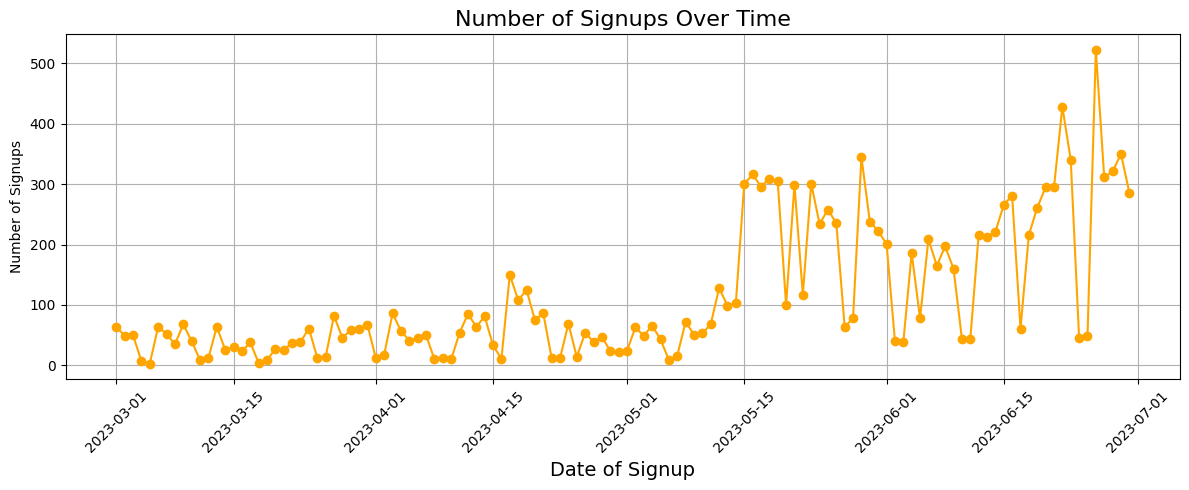

In [34]:
data['date_of_signup'] = pd.to_datetime(data['date_of_signup'])
signup_counts = data.groupby("date_of_signup").size()

plt.figure(figsize=(12, 5))
plt.plot(signup_counts.index, signup_counts.values, marker='o', linestyle='-', color='orange')
plt.title('Number of Signups Over Time', fontsize=16)
plt.xlabel('Date of Signup', fontsize=14)
plt.ylabel('Number of Signups')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This latest exploratory analysis reveals a significant spike in contract sign-ups by Octopus around mid-May 2023. Prior to this date, sign-ups were relatively stable, with little fluctuation and an average of around 50 sign-ups per day. However, from mid-May, a considerable increase in enrolments was observed, with a much more pronounced variation, even peaking at over 500 contracts signed daily towards the end of June. In spite of this boom, it is interesting to note that some days the number of enrolments returned to a lower level, resuming the average of around 50 enrolments per day. 

## Prediction
This part of the analysis leads to the creation of the customer churn prediction model, a method that allows the company to identify which customers might abandon the service. As mentioned earlier, the objective is to predict the risk of abandonment and take corrective measures to improve retention.

The first step in this process is the preparation of the final dataset to be used for prediction. In this phase, new variables are generated that allow a more detailed understanding of customer behaviour. For example, the variable ‘days_to_start’ was created, which indicates the number of days between the first supply of energy and the signup of the contract, giving an indication of the time between activation and the actual start of the service. In addition, binary variables such as ‘has_changed_product’ were introduced, which takes the value 1 if the customer's product category has changed over time and 0 if it has remained unchanged. This helps to understand whether the change in the contract can influence the probability of churn. In addition, a label encoding process was performed to convert categorical and numerical variables into a encoded form or as dummy variables.
Finally, other variables such as ‘type_of_incoming_voltage’, ‘supply_end_date’, ‘age_of_customer’ and ‘supply_province’ were removed.

The final dataset contains the dependent variable ‘has_churned’, which is binary and takes the values True (if the customer has left the service) or False (if the customer has remained). The other variables are independent and represent different characteristics of the customer (such as age, gender, date of enrolment) and information about the customer's behaviour.

### Data Preparation for Prediction

In [35]:
data_predict = data_age.copy()

In [36]:
data_predict['anonymised_sales_subchannel'].unique()

array(['ed168885785', '4c5627f1c90', 'e9836ec5e6d', 'c6e190b2846',
       '844f5b994f8', '1f42dff7fbe', 'cbdaba56059', 'd41d8cd98f0'],
      dtype=object)

In [37]:
data_predict

,sales_channel,anonymised_sales_subchannel,supply_province,age_of_customer,sex_of_customer,type_of_voltura_incoming,first_product_category,last_product_category,date_of_signup,supply_start_date,supply_end_date,has_churned,age_category,zone
0,Direct,ed168885785,TV,62.0,M,NaN,FIX,FIX,2023-06-20,2023-08-01,NaN,False,Over 50,North-East
1,Price Comparison,4c5627f1c90,BR,41.0,M,NaN,FIX,FIX,2023-06-30,2023-08-01,2023-08-31,True,40-50,South
2,Price Comparison,4c5627f1c90,NU,68.0,M,NaN,FLEX,FLEX,2023-05-11,2023-07-01,NaN,False,Over 50,Islands
3,Price Comparison,4c5627f1c90,AG,53.0,M,NaN,FIX,FLEX,2023-06-27,2023-08-01,NaN,False,Over 50,Islands
4,Direct,ed168885785,MI,51.0,M,NaN,FIX,FLEX,2023-06-23,2023-08-01,NaN,False,Over 50,North-West
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13878,Direct,ed168885785,AR,51.0,M,NaN,FLEX MONO,FLEX MONO,2023-06-04,2023-08-01,NaN,False,Over 50,Center
13879,Price Comparison,4c5627f1c90,CA,65.0,M,NaN,FIX,FIX,2023-04-21,2023-06-01,NaN,False,Over 50,Islands
13880,Price Comparison,4c5627f1c90,PC,33.0,M,NaN,FIX,FIX,2023-06-30,2023-08-01,2023-12-31,True,30-40,North-East
13881,Price Comparison,4c5627f1c90,VB,36.0,F,NaN,FIX,FIX,2023-05-18,2023-07-01,NaN,False,30-40,North-West


In [38]:
data_predict['supply_start_date'] = pd.to_datetime(data_predict['supply_start_date'])
data_predict['date_of_signup'] = pd.to_datetime(data_predict['date_of_signup'])
data_predict['days_to_start'] = (data_predict['supply_start_date'] - data_predict['date_of_signup']).dt.days
data_predict['days_to_start'].describe()

count    13883.000000
mean        41.314269
std         31.778772
min       -424.000000
25%         36.000000
50%         43.000000
75%         49.000000
max        421.000000
Name: days_to_start, dtype: float64

In [ ]:
data_predict['last_product_category'] = data_predict['last_product_category'].str.strip()
data_predict['has_changed_product'] = (data_predict['first_product_category'] != data_predict['last_product_category']).astype(int)
data_predict = pd.get_dummies(data_predict, columns=['sales_channel', 'zone', 'first_product_category', 'last_product_category'], drop_first=True)
data_predict['anonymised_sales_subchannel'] = data_predict['anonymised_sales_subchannel'].astype('category').cat.codes
data_predict['age_category'] = data_predict['age_category'].astype('category').cat.codes
data_predict['month_of_signup'] = data_predict['date_of_signup'].dt.month
data_predict['sex_of_customer'] = data_predict['sex_of_customer'].map({'M': 0, 'F': 1})

In [40]:
data_predict = data_predict.drop(['type_of_voltura_incoming', 'supply_end_date', 'age_of_customer', 'supply_province'], axis=1)

In [41]:
data_predict.head()

,anonymised_sales_subchannel,sex_of_customer,date_of_signup,supply_start_date,has_churned,age_category,days_to_start,has_changed_product,sales_channel_Field Sales,sales_channel_New tenant,sales_channel_Price Comparison,zone_Islands,zone_North-East,zone_North-West,zone_South,first_product_category_FLEX,first_product_category_FLEX MONO,last_product_category_FLEX,last_product_category_FLEX MONO,month_of_signup
0,7,0,2023-06-20,2023-08-01,False,3,42,0,False,False,False,False,True,False,False,False,False,False,False,6
1,1,0,2023-06-30,2023-08-01,True,2,32,0,False,False,True,False,False,False,True,False,False,False,False,6
2,1,0,2023-05-11,2023-07-01,False,3,51,0,False,False,True,True,False,False,False,True,False,True,False,5
3,1,0,2023-06-27,2023-08-01,False,3,35,1,False,False,True,True,False,False,False,False,False,True,False,6
4,7,0,2023-06-23,2023-08-01,False,3,39,1,False,False,False,False,False,True,False,False,False,True,False,6


In [42]:
data_predict.isnull().sum()

anonymised_sales_subchannel         0
sex_of_customer                     0
date_of_signup                      0
supply_start_date                   0
has_churned                         0
age_category                        0
days_to_start                       0
has_changed_product                 0
sales_channel_Field Sales           0
sales_channel_New tenant            0
sales_channel_Price Comparison      0
zone_Islands                        0
zone_North-East                     0
zone_North-West                     0
zone_South                          0
first_product_category_FLEX         0
first_product_category_FLEX MONO    0
last_product_category_FLEX          0
last_product_category_FLEX MONO     0
month_of_signup                     0
dtype: int64

In [43]:
len(data_predict)

13883

In [44]:
data_predict = data_predict.drop(['supply_start_date', 'date_of_signup'], axis=1)

In [45]:
data_predict['has_changed_product'].value_counts()

has_changed_product
0    10767
1     3116
Name: count, dtype: int64

The final dataset includes 10,767 customers who did not change their contract and 3,116 customers who did.

### Correlation Matrix

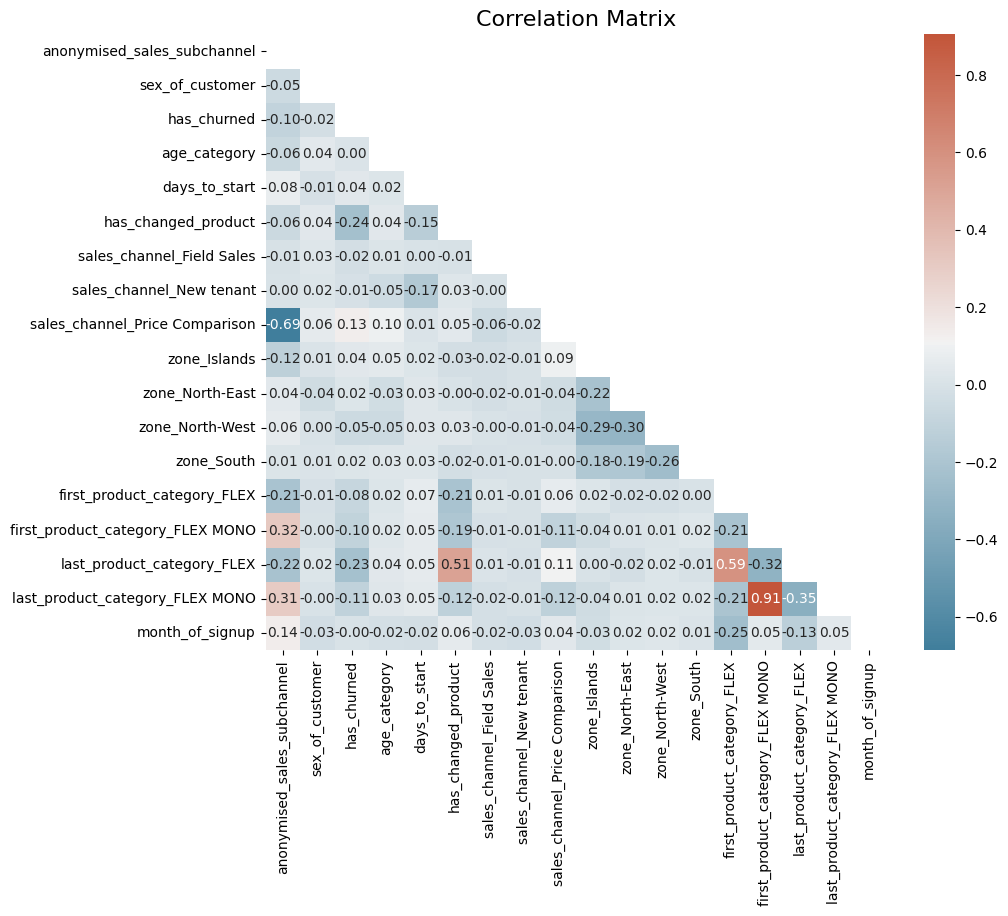

In [46]:
plt.figure(figsize=(10, 8))
corr = data_predict.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, fmt=".2f")
plt.title('Correlation Matrix', fontsize=16)
plt.show()

The correlation matrix does not show particularly strong correlations between the variables, suggesting that the characteristics of the dataset are not closely related. However, an interesting aspect that emerges is that customers with a ‘flex mono’ contract show a very high correlation, indicating a certain stability among those opting for this type of contract. This confirm what we say before: customers with a ‘flex mono’ contract tend not change their contract.

### Train-Test Split

Next came the phase of creating the training and testing dataset to train and evaluate the performance of the churn prediction model. Twenty per cent of the dataset was reserved for testing the model, allowing its ability to generalise to unseen data to be evaluated. The remaining 80% of the dataset was used to train the model.

In [47]:
X = data_predict.drop('has_churned', axis=1)
y = data_predict['has_churned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Evaluation Function

In [48]:
def evaluate_models(models, X_train, y_train, X_test, y_test, resampling_technique=None):
    if resampling_technique:
        print(f"Applying resampling technique: {resampling_technique.__class__.__name__}")
        print("-"*50)
        X_resampled, y_resampled = resampling_technique.fit_resample(X_train, y_train)
    else:
        X_resampled, y_resampled = X_train, y_train

    results = []

    for model_name, model in models:
        print(f"Evaluating model: {model_name}")
        model.fit(X_resampled, y_resampled.ravel())
        predictions = model.predict(X_test)
        
        acc = accuracy_score(y_test, predictions)
        f1 = f1_score(y_test, predictions, average='binary')
        cm = confusion_matrix(y_test, predictions)

        results.append({
            'Model': model_name,
            'Accuracy': round(acc, 3),
            'F1 Score': round(f1, 3),
            'Confusion Matrix': cm
        })
        
        print(f"\tClassification Report:")
        print(classification_report(y_test, predictions))
        print("\tConfusion Matrix:")
        print(pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1']))
        print("="*50)

    return pd.DataFrame(results)

### Model Evaluation with Hyperparameter Tuning

In [49]:
def evaluate_models(models, X_train, y_train, X_test, y_test, 
                    resampling_technique=None, 
                    hyperparameter_grids=None, 
                    cv=5):
    if resampling_technique:
        print(f"Applying resampling technique: {resampling_technique.__class__.__name__}")
        print("-"*50)
        X_resampled, y_resampled = resampling_technique.fit_resample(X_train, y_train)
    else:
        X_resampled, y_resampled = X_train, y_train
    
    results = []
    
    for model_name, model in models:
        print(f"Evaluating model: {model_name}")
        
        try:
            if hyperparameter_grids and model_name in hyperparameter_grids:
                print("\tPerforming Hyperparameter Tuning")
                grid_search = GridSearchCV(
                    estimator=model, 
                    param_grid=hyperparameter_grids[model_name],
                    cv=cv,
                    scoring=['accuracy', 'f1'],
                    refit='f1'
                )
                grid_search.fit(X_resampled, y_resampled.ravel())
                
                best_model = grid_search.best_estimator_
                best_params = grid_search.best_params_
                print(f"\tBest Parameters: {best_params}")
            else:
                best_model = model
                best_model.fit(X_resampled, y_resampled.ravel())
                best_params = {}
        except Exception as e: # XGBoost throws error
            print(f"\tHyperparameter tuning failed: {e}")
            best_model = model
            best_model.fit(X_resampled, y_resampled.ravel())
            best_params = {}
        
        predictions = best_model.predict(X_test)
        
        acc = accuracy_score(y_test, predictions)
        f1 = f1_score(y_test, predictions, average='binary')
        cm = confusion_matrix(y_test, predictions)
        importance = best_model.feature_importances_ if hasattr(best_model, 'feature_importances_') else None
        result_entry = {
            'Model': model_name,
            'Accuracy': round(acc, 3),
            'F1 Score': round(f1, 3),
            'Confusion Matrix': cm,
            'Best Parameters': best_params,
            'Feature Importance': importance
        }
        results.append(result_entry)
        
        print(f"\tClassification Report:")
        print(classification_report(y_test, predictions))
        print("\tConfusion Matrix:")
        print(pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1']))
        print("="*50)
    
    return pd.DataFrame(results)

### Model Definitions and Hyperparameter Grids

In [50]:
models = [
    ("Random Forest", RandomForestClassifier(min_samples_leaf=100, random_state=10)),
    ("Logistic Regression", LogisticRegression(random_state=20, max_iter=1000)),
    ("XGBoost", XGBClassifier(eta=0.1, max_depth=5))
]
hyperparameter_grids = {
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
         'penalty': ['l1', 'l2']
    },
    "Random Forest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15]
    },
    "XGBoost": {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15]
    }
}

undersample = RandomUnderSampler(random_state=0)
oversample = SMOTE(random_state=0)

The final result will be obtained through the construction of three machine learning models: Random Forest, Logistic Regression and XGBoost. Each model was configured with specific parameters to optimise performance.

- Random Forest was set with a minimum leaf parameter of 100, to limit the minimum number of samples within a leaf, in order to achieve a more meaningful division of the data and prevent overfitting.
- Logistic Regression was configured with a parameter of 1000 maximum iterations to ensure that the model can converge correctly during training, especially on complex or non-linearly separable datasets.
- XGBoost was set with a learning rate of 0.1 and a max depth of 5, to limit the depth of the trees and reduce the risk of overfitting, improving the generalisation of the model.
For each model, grids of hyperparameters were defined to further optimise performance and obtain the best possible result. This process of searching for hyperparameters makes it possible to explore different combinations of parameters and choose those that maximise the accuracy of the model.

In addition, two resampling techniques were used to balance the dataset and manage the unbalanced distribution of classes:
- Random Under-Sampling, which reduces the number of samples from the majority class in the dataset, so as to achieve a balance between the classes. This technique helps prevent the model from favouring the majority class, improving the prediction for the minority class.
- SMOTE (Synthetic Minority Over-sampling Technique), an oversampling technique that generates new synthetic samples of the minority class. SMOTE creates artificial samples instead of simply duplicating existing samples, helping to improve the model's ability to learn and generalise about minority class characteristics.

### Model Evaluation

In [51]:
result_normal = evaluate_models(models, X_train, y_train, X_test, y_test, resampling_technique=None, hyperparameter_grids=hyperparameter_grids)

Evaluating model: Random Forest
	Performing Hyperparameter Tuning
	Best Parameters: {'max_depth': 10, 'n_estimators': 100}
	Classification Report:
              precision    recall  f1-score   support

       False       0.76      0.86      0.80      1911
        True       0.56      0.39      0.46       866

    accuracy                           0.71      2777
   macro avg       0.66      0.62      0.63      2777
weighted avg       0.69      0.71      0.70      2777

	Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         1642          269
Actual 1          530          336
Evaluating model: Logistic Regression
	Performing Hyperparameter Tuning
	Best Parameters: {'C': 100, 'penalty': 'l2'}
	Classification Report:
              precision    recall  f1-score   support

       False       0.76      0.85      0.80      1911
        True       0.56      0.42      0.48       866

    accuracy                           0.71      2777
   macro avg       0.66      0.63      0.6

As a first step, the models were evaluated without performing any undersampling or oversampling techniques, to observe the initial performance of the three models using the training and test data. Below are the general results obtained for each model:

- Random Forest: The best set of hyperparameters for the Random Forest model was found with a maximum depth of 10 and a number of estimators of 100. This model showed a good ability to identify true negatives, but performed relatively poorly in correctly detecting true positives. The overall accuracy was 0.71, a good result indicating that the model is effective in classifying cases, although it needs improvement in predicting the positive class.
- Logistic Regression: The best hyperparameters for the logistic regression model were found with a regularisation parameter of 100 and an L2 penalty parameter. The L2 regularisation helps to reduce overfitting without removing important variables from the model, helping to improve generalisation. As in the case of the Random Forest, the logistic regression showed a lower performance in correctly detecting the positive class, suggesting that the model may need further refinement. The accuracy was identical to that of the Random Forest model, but the logistic regression model seemed slightly less effective in classifying the positive class.
- XGBoost: The same problem of a lower performance in classifying the positive class was also found for the XGBoost model. In this particular case the model had difficulty correctly identifying true positives.

In general, all three models showed some difficulty in correctly identifying the positive class, an aspect that could be improved by using resampling techniques, such as Random Under-Sampling or SMOTE, to balance the dataset and optimise the model's predictive ability on the minority class.



In [52]:
result_under = evaluate_models(models, X_train, y_train, X_test, y_test, resampling_technique=undersample, hyperparameter_grids=hyperparameter_grids)

Applying resampling technique: RandomUnderSampler
--------------------------------------------------
Evaluating model: Random Forest
	Performing Hyperparameter Tuning
	Best Parameters: {'max_depth': 5, 'n_estimators': 100}
	Classification Report:
              precision    recall  f1-score   support

       False       0.82      0.65      0.72      1911
        True       0.47      0.68      0.55       866

    accuracy                           0.66      2777
   macro avg       0.64      0.66      0.64      2777
weighted avg       0.71      0.66      0.67      2777

	Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         1239          672
Actual 1          279          587
Evaluating model: Logistic Regression
	Performing Hyperparameter Tuning
	Best Parameters: {'C': 10, 'penalty': 'l2'}
	Classification Report:
              precision    recall  f1-score   support

       False       0.82      0.64      0.72      1911
        True       0.46      0.69      0.55       86

Next, the models were evaluated using the undersampling technique, which reduces the number of records in the majority class to balance the classes and reduce the risk of the model learning too much from the dominant class, as was the case previously. Analysing the results of the Random Forest, Logistic Regression and XGBoost models, significant differences in accuracy and F1 score emerge.

Without the use of undersampling, the overall accuracy for each model was 0.71, which reflects a good level of classification. However, when the RandomUnderSampler technique is applied, a decrease in accuracy is observed. In fact, this parameter drops to 0.66 for all models, suggesting that the reduction of samples from the majority class resulted in a loss of overall accuracy in the model. Despite this, the F1 Score analysis reveals significant improvements.

Without undersampling, the F1 Score for the positive class (True) was low, but with the application of the undersampling technique, the F1 Score improves significantly to 0.55. This indicates that the use of undersampling reduced overfitting on the majority class, making the model much more balanced and effective in correctly classifying the minority class, that is, customers at risk of churn.

A similar effect is observed for the value of the Recall, which shows a significant improvement due to the balancing of classes. The Recall for the positive class (True) increases, indicating that the model can more successfully identify customers who will actually leave the service.

This phenomenon is also repeated when the oversampling technique is applied. Although there is a decrease in accuracy, the F1 Score and Recall for the positive class improve significantly. Oversampling, which generates synthetic samples for the minority class, in fact helps to balance the dataset, improving the predictive capabilities of the model with respect to the class that has fewer samples.

In conclusion, both undersampling and oversampling help improve the model, especially in its ability to correctly predict which customers will churn, although these approaches affect evaluation metrics such as accuracy and F1 Score differently.

In [53]:
result_over = evaluate_models(models, X_train, y_train, X_test, y_test, resampling_technique=oversample, hyperparameter_grids=hyperparameter_grids)

Applying resampling technique: SMOTE
--------------------------------------------------
Evaluating model: Random Forest
	Performing Hyperparameter Tuning
	Best Parameters: {'max_depth': 10, 'n_estimators': 200}
	Classification Report:
              precision    recall  f1-score   support

       False       0.82      0.64      0.72      1911
        True       0.47      0.69      0.56       866

    accuracy                           0.66      2777
   macro avg       0.64      0.67      0.64      2777
weighted avg       0.71      0.66      0.67      2777

	Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         1230          681
Actual 1          268          598
Evaluating model: Logistic Regression
	Performing Hyperparameter Tuning
	Best Parameters: {'C': 100, 'penalty': 'l2'}
	Classification Report:
              precision    recall  f1-score   support

       False       0.82      0.66      0.73      1911
        True       0.47      0.67      0.55       866

    accu

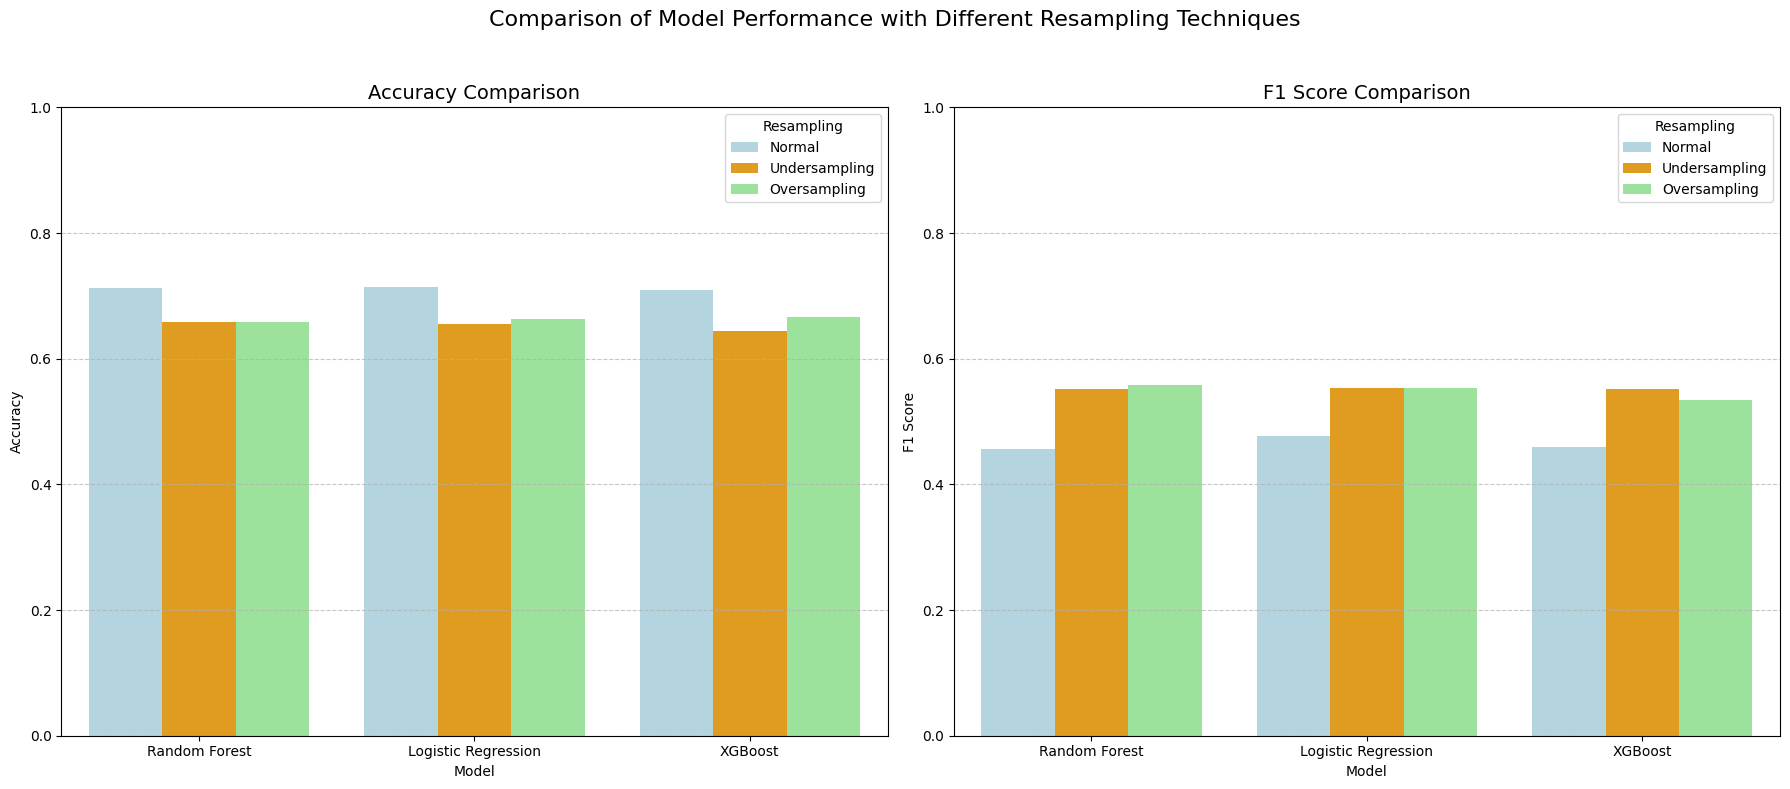

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

result_normal['Resampling'] = 'Normal'
result_under['Resampling'] = 'Undersampling'
result_over['Resampling'] = 'Oversampling'
all_results = pd.concat([result_normal, result_under, result_over])

sns.barplot(
    x='Model', 
    y='Accuracy', 
    hue='Resampling', 
    data=all_results, 
    ax=ax[0], 
    palette=['lightblue', 'orange', 'lightgreen']
)
ax[0].set_title('Accuracy Comparison', fontsize=14)
ax[0].set_ylim(0, 1)
ax[0].grid(axis='y', linestyle='--', alpha=0.7)
ax[0].set_ylabel('Accuracy')
ax[0].legend(title='Resampling', loc='upper right', fontsize=10)

sns.barplot(
    x='Model', 
    y='F1 Score', 
    hue='Resampling', 
    data=all_results, 
    ax=ax[1], 
    palette=['lightblue', 'orange', 'lightgreen']
)
ax[1].set_title('F1 Score Comparison', fontsize=14)
ax[1].set_ylim(0, 1)
ax[1].grid(axis='y', linestyle='--', alpha=0.7)
ax[1].set_ylabel('F1 Score')
ax[1].legend(title='Resampling', loc='upper right', fontsize=10)

plt.suptitle('Comparison of Model Performance with Different Resampling Techniques', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

The graph confirms the trend that has been observed in previous analyses, undersampling and oversampling, although causing a slight decrease in overall accuracy, leads to a significant improvement in the model's performance in classifying the positive class.

In [55]:
for resampling in ['Normal', 'Undersampling', 'Oversampling']:
    best_model = all_results[all_results['Resampling'] == resampling].sort_values('F1 Score', ascending=False).iloc[0]
    print(f"Best model for {resampling}: {best_model['Model']}")
    print(f"\tAccuracy: {best_model['Accuracy']}")
    print(f"\tF1 Score: {best_model['F1 Score']}")
    print(f"\tBest Parameters: {best_model['Best Parameters']}")
    print("="*50)

Best model for Normal: Logistic Regression
	Accuracy: 0.714
	F1 Score: 0.477
	Best Parameters: {'C': 100, 'penalty': 'l2'}
Best model for Undersampling: Logistic Regression
	Accuracy: 0.655
	F1 Score: 0.554
	Best Parameters: {'C': 10, 'penalty': 'l2'}
Best model for Oversampling: Random Forest
	Accuracy: 0.658
	F1 Score: 0.558
	Best Parameters: {'max_depth': 10, 'n_estimators': 200}


### Feature Importance

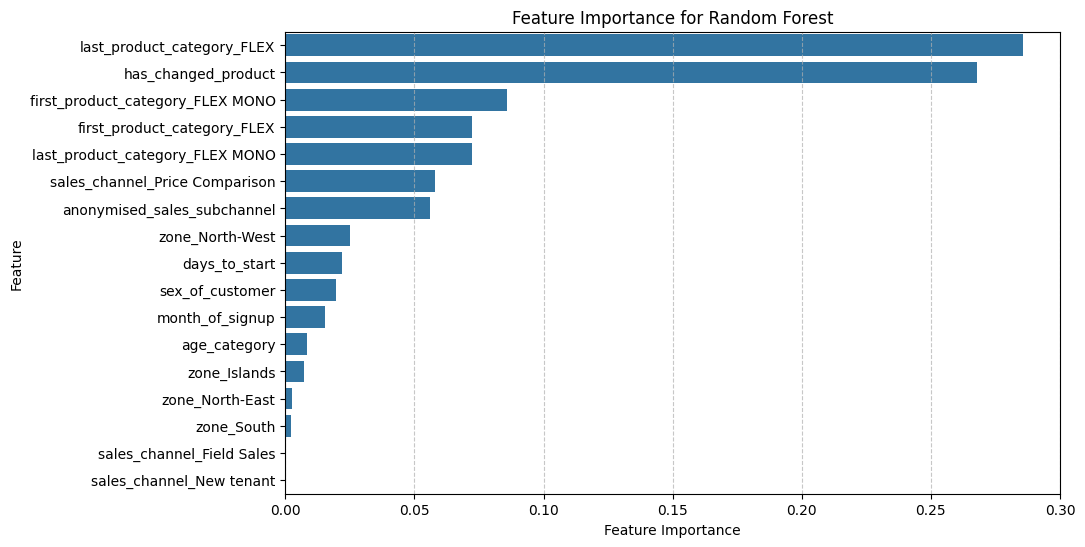

In [56]:
best_model = all_results.sort_values('F1 Score', ascending=False).iloc[0]
feature_importance = best_model['Feature Importance']

if feature_importance is not None:
    feature_names = X.columns
    sorted_idx = np.argsort(feature_importance)[::-1]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance[sorted_idx], y=feature_names[sorted_idx])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title(f'Feature Importance for {best_model["Model"]}')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

Finally, we want to visualize the importance of the features for the best model obtained. The F1 Score was chosen as a metric to choose the best model because it is a good metric to balance precision and recall and it is useful when the classes are imbalanced. Having the flexible contract as the last product category and switching from one product to another had a very significant influence on the model's prediction. This makes logical sense as they are variables that reflect behaviors and decisions that affect the probability of a customer abandoning. This could mean that customers who opt for a flexible product category could be more inclined to evaluate other alternatives, with a higher risk of churn. Furthermore, if the customer has changed products during his experience with the company, it can indicate dissatisfaction and a desire to find a better solution for his needs. These customers could be much more predisposed to churn, as they do not seem to be able to find a stable and satisfactory solution.